### Reddit post classification

The aim of this jupyter notebook is to be able to accurately classify the given posts, based on the given columns of the dataset, as one of 3 classes. The three classes which are available to us include 'artificial', 'datascience' and 'MachineLearning'. The uniquesness of this problem lies in the fact that there are 2 parts to this dataset. Namely, the post information in a dataset called 'Top_Posts.csv' and a second part that is called 'Top_Posts_Comments.csv'. The second file corresponds to the set of multiple comments that were originally posted under the post. Using all this data, we will aim to accurately classify images as belonging to their respective classes.

#### Importing relevant packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anuraagmuktevi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anuraagmuktevi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading post data

In [2]:
post_data = pd.read_csv('reddit/Top_Posts.csv')
post_data

,post_id,post_title,subreddit,post_url,flair_text,score,comments,upvote_ratio,date-time,year
0,gh1dj9,[Project] From books to presentations in 10s w...,MachineLearning,https://v.redd.it/v492uoheuxx41,Project,7798,186,0.99,2020-05-10 13:19:54,2020
1,kuc6tz,[D] A Demo from 1993 of 32-year-old Yann LeCun...,MachineLearning,https://v.redd.it/25nxi9ojfha61,Discussion,5851,133,0.98,2021-01-10 10:30:36,2021
2,g7nfvb,[R] First Order Motion Model applied to animat...,MachineLearning,https://v.redd.it/rlmmjm1q5wu41,Research,4761,111,0.97,2020-04-25 04:27:23,2020
3,lui92h,[N] AI can turn old photos into moving Images ...,MachineLearning,https://v.redd.it/ikd5gjlbi8k61,News,4688,230,0.97,2021-02-28 15:12:28,2021
4,ohxnts,[D] This AI reveals how much time politicians ...,MachineLearning,https://i.redd.it/34sgziebfia71.jpg,Discussion,4568,228,0.96,2021-07-11 04:18:59,2021
...,...,...,...,...,...,...,...,...,...,...
2982,slx33m,We live in beautiful times where you can learn...,artificial,https://github.com/louisfb01/start-machine-lea...,Discussion,84,6,0.90,2022-02-06 13:50:02,2022
2983,k9otbj,Yann LeCun’s Deep Learning Course Free From NYU,artificial,https://www.i-programmer.info/news/99-professi...,News,78,1,0.97,2020-12-09 09:22:52,2020
2984,k2orib,You Can Now Learn for FREE: 9 Courses by Googl...,artificial,https://laconicml.com/free-artificial-intellig...,Self Promotion,80,2,0.95,2020-11-28 14:43:43,2020
2985,ex9w4w,"Chatbot trained on ""public domain social media...",artificial,https://ai.googleblog.com/2020/01/towards-conv...,news,80,10,0.97,2020-02-01 17:55:23,2020


#### In the below steps, we analyse the post data to identify the the values present in the columns, the columns where the values are missing and the distribution of values in the columns

In [3]:
post_data.head()

,post_id,post_title,subreddit,post_url,flair_text,score,comments,upvote_ratio,date-time,year
0,gh1dj9,[Project] From books to presentations in 10s w...,MachineLearning,https://v.redd.it/v492uoheuxx41,Project,7798,186,0.99,2020-05-10 13:19:54,2020
1,kuc6tz,[D] A Demo from 1993 of 32-year-old Yann LeCun...,MachineLearning,https://v.redd.it/25nxi9ojfha61,Discussion,5851,133,0.98,2021-01-10 10:30:36,2021
2,g7nfvb,[R] First Order Motion Model applied to animat...,MachineLearning,https://v.redd.it/rlmmjm1q5wu41,Research,4761,111,0.97,2020-04-25 04:27:23,2020
3,lui92h,[N] AI can turn old photos into moving Images ...,MachineLearning,https://v.redd.it/ikd5gjlbi8k61,News,4688,230,0.97,2021-02-28 15:12:28,2021
4,ohxnts,[D] This AI reveals how much time politicians ...,MachineLearning,https://i.redd.it/34sgziebfia71.jpg,Discussion,4568,228,0.96,2021-07-11 04:18:59,2021


In [4]:
post_data.columns

Index(['post_id', 'post_title', 'subreddit', 'post_url', 'flair_text', 'score',
       'comments', 'upvote_ratio', 'date-time', 'year'],
      dtype='object')

In [5]:
post_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987 entries, 0 to 2986
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   post_id       2987 non-null   object 
 1   post_title    2987 non-null   object 
 2   subreddit     2987 non-null   object 
 3   post_url      2987 non-null   object 
 4   flair_text    2441 non-null   object 
 5   score         2987 non-null   int64  
 6   comments      2987 non-null   int64  
 7   upvote_ratio  2987 non-null   float64
 8   date-time     2987 non-null   object 
 9   year          2987 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 233.5+ KB


In [6]:
post_data.describe(include='all')

,post_id,post_title,subreddit,post_url,flair_text,score,comments,upvote_ratio,date-time,year
count,2987,2987,2987,2987,2441,2987.000000,2987.000000,2987.000000,2987,2987.000000
unique,2987,2975,3,2971,33,NaN,NaN,NaN,2987,NaN
top,gh1dj9,An interesting job posting I found for a Work ...,artificial,https://youtu.be/aircAruvnKk,Discussion,NaN,NaN,NaN,2020-05-10 13:19:54,NaN
freq,1,3,999,2,728,NaN,NaN,NaN,1,NaN
mean,NaN,NaN,NaN,NaN,NaN,480.092400,72.939739,0.950683,NaN,2020.276197
std,NaN,NaN,NaN,NaN,NaN,519.716958,92.253969,0.039040,NaN,1.783035
min,NaN,NaN,NaN,NaN,NaN,78.000000,0.000000,0.660000,NaN,2013.000000
25%,NaN,NaN,NaN,NaN,NaN,183.000000,19.000000,0.940000,NaN,2019.000000
50%,NaN,NaN,NaN,NaN,NaN,360.000000,45.000000,0.960000,NaN,2020.000000
75%,NaN,NaN,NaN,NaN,NaN,542.500000,99.500000,0.980000,NaN,2022.000000


#### In the below cells we can see that there are values missing only in the 'flair_text' column. The rest of the columns have all the values present. However, since more than 80% of the values are present, we can keep the flair_text column for now. In addition to this, we can drop all the missing values from the dataframe.

In [7]:
missing_percentages = 100 * post_data.isna().sum() / len(post_data)
print("Missing Percentage : ",missing_percentages)
columns_with_missing_values = missing_percentages[missing_percentages > 20].index.tolist()
print("Columns with more than 20% missing values:", columns_with_missing_values)

Missing Percentage :  post_id          0.00000
post_title       0.00000
subreddit        0.00000
post_url         0.00000
flair_text      18.27921
score            0.00000
comments         0.00000
upvote_ratio     0.00000
date-time        0.00000
year             0.00000
dtype: float64
Columns with more than 20% missing values: []


In [8]:
post_data = post_data.dropna()

#### In the following steps, we can analyse the 'Top_Posts_Comments.csv' in much the same way as the 'Top_Posts.csv'. 

In [9]:
comments_data = pd.read_csv('reddit/Top_Posts_Comments.csv')
comments_data

,post_id,comment
0,gh1dj9,Twitter thread: [https://twitter.com/cyrildiag...
1,gh1dj9,The future 🤯
2,gh1dj9,Simple yet very useful. Thank you for sharing ...
3,gh1dj9,"Almost guaranteed, Apple will copy your idea i..."
4,gh1dj9,Ohh the nightmare of making this into a stable...
...,...,...
223169,efk5n3,LiDAR is mot powerful sensor for the auto driv...
223170,efk5n3,So it can now idenrify traffic lights? Musk pr...
223171,efk5n3,Hydranet bro!
223172,efk5n3,It even shows flashing yellow turn arrows.


In [10]:
comments_data.head()

,post_id,comment
0,gh1dj9,Twitter thread: [https://twitter.com/cyrildiag...
1,gh1dj9,The future 🤯
2,gh1dj9,Simple yet very useful. Thank you for sharing ...
3,gh1dj9,"Almost guaranteed, Apple will copy your idea i..."
4,gh1dj9,Ohh the nightmare of making this into a stable...


In [11]:
comments_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223174 entries, 0 to 223173
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   post_id  223174 non-null  object
 1   comment  223159 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [12]:
print("Number of unique posts : ",post_data['post_id'].nunique())
print("Number of unique posts for which comments exist: ",comments_data['post_id'].nunique())

Number of unique posts :  2441
Number of unique posts for which comments exist:  2988


#### Finally, we merge the 'Top_Posts' and 'Top_Posts_Comments' csvs together to generate the 'merged_data' dataframe, which we can use to analyse the data and perform the predictions. In order to do this, a new column called 'comment' is created with all the comments of the 'Top_Posts_Comments' dataset merged together, seperated by a pipe character "|". In addition to merging the data, we also add a new column that measures the number of comments in each post of the 'Top_Posts' data.

In [13]:
comments_data['comment'] = comments_data['comment'].astype(str)
grouped_comments = comments_data.groupby('post_id')['comment'].agg(lambda x: ' | '.join(x)).reset_index()
merged_data = pd.merge(grouped_comments, post_data, on='post_id')
merged_data['num_comments'] = comments_data.groupby('post_id').size().reset_index(drop=True)
merged_data

,post_id,comment,post_title,subreddit,post_url,flair_text,score,comments,upvote_ratio,date-time,year,num_comments
0,1008i6v,That's really impressive. And thankfully it di...,ChatGPT wrote a recipe based on what's in my c...,artificial,https://www.reddit.com/r/artificial/comments/1...,AGI,184,40,0.98,2023-01-01 01:14:47,2023,41
1,101fixa,So i get paid by being able to use and talk ab...,An interesting job posting I found for a Work ...,datascience,https://i.imgur.com/pJqTyyA.jpg,Discussion,424,73,0.93,2023-01-02 15:38:32,2023,75
2,101t0vt,Some relevant math:\n\n ...,Here’s another predatory unpaid internship tha...,datascience,https://i.redd.it/rj25hpromr9a1.jpg,Discussion,619,59,0.97,2023-01-03 00:38:42,2023,58
3,1027spa,How do you take care the consistency / permane...,In 3 months I've created 3 comics and 3 mangas...,artificial,https://www.reddit.com/gallery/1027spa,Self Promotion,297,124,0.89,2023-01-03 13:08:34,2023,126
4,102h06p,/r/BossFights\n\nData Xientist - Creator of St...,The most epic DS job title,datascience,https://i.redd.it/ye9pa0ak8x9a1.jpg,Discussion,506,45,0.96,2023-01-03 19:30:13,2023,45
...,...,...,...,...,...,...,...,...,...,...,...,...
2431,zy3xbl,hello,How To Create Youtube Custom Thumbnail Using M...,artificial,https://youtu.be/96nmgLgOebM,Tutorial,84,1,0.88,2022-12-29 12:10:44,2022,46
2432,zy8c99,Very impressive. \n\n* Love the color coding b...,[R] Cramming: Training a Language Model on a S...,MachineLearning,https://arxiv.org/abs/2212.14034,Research,358,26,0.98,2022-12-29 15:41:26,2022,103
2433,zycjcl,"That's weird, I tried myself and it won't do i...",ChatGPT's Gender Sensitivity: Is It Joking Abo...,artificial,https://i.redd.it/zag7mgdw9x8a1.jpg,News,451,67,0.87,2022-12-29 18:33:34,2022,123
2434,zys7g5,“Hands on experience” in “real world” NLP… but...,The job description of this unpaid internship ...,datascience,https://www.reddit.com/gallery/zys7g5,Fun/Trivia,756,134,0.98,2022-12-30 05:33:24,2022,20


#### In the next step, we prepare our data for perfomance of bayesian classification of the 'comments' column and the 'post_title' column of the merged data set. The outputs of these predictions will be used to augment our dataset with new data.

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [15]:
merged_data['comments_processed'] = merged_data['comment'].apply(preprocess_text)
merged_data

,post_id,comment,post_title,subreddit,post_url,flair_text,score,comments,upvote_ratio,date-time,year,num_comments,comments_processed
0,1008i6v,That's really impressive. And thankfully it di...,ChatGPT wrote a recipe based on what's in my c...,artificial,https://www.reddit.com/r/artificial/comments/1...,AGI,184,40,0.98,2023-01-01 01:14:47,2023,41,thats really impressive thankfully didnt adopt...
1,101fixa,So i get paid by being able to use and talk ab...,An interesting job posting I found for a Work ...,datascience,https://i.imgur.com/pJqTyyA.jpg,Discussion,424,73,0.93,2023-01-02 15:38:32,2023,75,get paid able use talk data yeah thanks teach ...
2,101t0vt,Some relevant math:\n\n ...,Here’s another predatory unpaid internship tha...,datascience,https://i.redd.it/rj25hpromr9a1.jpg,Discussion,619,59,0.97,2023-01-03 00:38:42,2023,58,relevant math 110 people india agile aipowered...
3,1027spa,How do you take care the consistency / permane...,In 3 months I've created 3 comics and 3 mangas...,artificial,https://www.reddit.com/gallery/1027spa,Self Promotion,297,124,0.89,2023-01-03 13:08:34,2023,126,take care consistency permanence character art...
4,102h06p,/r/BossFights\n\nData Xientist - Creator of St...,The most epic DS job title,datascience,https://i.redd.it/ye9pa0ak8x9a1.jpg,Discussion,506,45,0.96,2023-01-03 19:30:13,2023,45,rbossfights data xientist creator stability wr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,zy3xbl,hello,How To Create Youtube Custom Thumbnail Using M...,artificial,https://youtu.be/96nmgLgOebM,Tutorial,84,1,0.88,2022-12-29 12:10:44,2022,46,hello
2432,zy8c99,Very impressive. \n\n* Love the color coding b...,[R] Cramming: Training a Language Model on a S...,MachineLearning,https://arxiv.org/abs/2212.14034,Research,358,26,0.98,2022-12-29 15:41:26,2022,103,impressive love color coding based didnt work ...
2433,zycjcl,"That's weird, I tried myself and it won't do i...",ChatGPT's Gender Sensitivity: Is It Joking Abo...,artificial,https://i.redd.it/zag7mgdw9x8a1.jpg,News,451,67,0.87,2022-12-29 18:33:34,2022,123,thats weird tried wont man woman httpswwwreddi...
2434,zys7g5,“Hands on experience” in “real world” NLP… but...,The job description of this unpaid internship ...,datascience,https://www.reddit.com/gallery/zys7g5,Fun/Trivia,756,134,0.98,2022-12-30 05:33:24,2022,20,hand experience real world nlp open people bac...


In [16]:
list(merged_data['subreddit'].unique())
label_map = {'artificial': 0, 'datascience': 1, 'MachineLearning': 2}
merged_data['label'] = merged_data['subreddit'].map(label_map)
merged_data

,post_id,comment,post_title,subreddit,post_url,flair_text,score,comments,upvote_ratio,date-time,year,num_comments,comments_processed,label
0,1008i6v,That's really impressive. And thankfully it di...,ChatGPT wrote a recipe based on what's in my c...,artificial,https://www.reddit.com/r/artificial/comments/1...,AGI,184,40,0.98,2023-01-01 01:14:47,2023,41,thats really impressive thankfully didnt adopt...,0
1,101fixa,So i get paid by being able to use and talk ab...,An interesting job posting I found for a Work ...,datascience,https://i.imgur.com/pJqTyyA.jpg,Discussion,424,73,0.93,2023-01-02 15:38:32,2023,75,get paid able use talk data yeah thanks teach ...,1
2,101t0vt,Some relevant math:\n\n ...,Here’s another predatory unpaid internship tha...,datascience,https://i.redd.it/rj25hpromr9a1.jpg,Discussion,619,59,0.97,2023-01-03 00:38:42,2023,58,relevant math 110 people india agile aipowered...,1
3,1027spa,How do you take care the consistency / permane...,In 3 months I've created 3 comics and 3 mangas...,artificial,https://www.reddit.com/gallery/1027spa,Self Promotion,297,124,0.89,2023-01-03 13:08:34,2023,126,take care consistency permanence character art...,0
4,102h06p,/r/BossFights\n\nData Xientist - Creator of St...,The most epic DS job title,datascience,https://i.redd.it/ye9pa0ak8x9a1.jpg,Discussion,506,45,0.96,2023-01-03 19:30:13,2023,45,rbossfights data xientist creator stability wr...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,zy3xbl,hello,How To Create Youtube Custom Thumbnail Using M...,artificial,https://youtu.be/96nmgLgOebM,Tutorial,84,1,0.88,2022-12-29 12:10:44,2022,46,hello,0
2432,zy8c99,Very impressive. \n\n* Love the color coding b...,[R] Cramming: Training a Language Model on a S...,MachineLearning,https://arxiv.org/abs/2212.14034,Research,358,26,0.98,2022-12-29 15:41:26,2022,103,impressive love color coding based didnt work ...,2
2433,zycjcl,"That's weird, I tried myself and it won't do i...",ChatGPT's Gender Sensitivity: Is It Joking Abo...,artificial,https://i.redd.it/zag7mgdw9x8a1.jpg,News,451,67,0.87,2022-12-29 18:33:34,2022,123,thats weird tried wont man woman httpswwwreddi...,0
2434,zys7g5,“Hands on experience” in “real world” NLP… but...,The job description of this unpaid internship ...,datascience,https://www.reddit.com/gallery/zys7g5,Fun/Trivia,756,134,0.98,2022-12-30 05:33:24,2022,20,hand experience real world nlp open people bac...,1


#### Before we actually perform bayesian classification, let us split our merged dataset into the final dataset and the bayes dataset, wherein the main dataset contains 80% of the examples and the bayes dataset contains 20% of the examples, which we will use to add some new features into the dataset.

In [17]:
final_data = merged_data.drop(['comment', 'subreddit'], axis=1)
final_data, bayes_data = train_test_split(final_data, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(bayes_data['comments_processed'], bayes_data['label'], test_size=0.2, random_state=42)
print("X_train : ",X_train.shape)
print("y_train : ",y_train.shape)
print("X_test : ",X_test.shape)
print("X_test : ",y_test.shape)
bayes_data

X_train :  (390,)
y_train :  (390,)
X_test :  (98,)
X_test :  (98,)


,post_id,post_title,post_url,flair_text,score,comments,upvote_ratio,date-time,year,num_comments,comments_processed,label
1964,uakf25,"Folks, am I crazy in thinking that a person th...",https://www.reddit.com/r/datascience/comments/...,Discussion,466,227,0.86,2022-04-24 02:08:06,2022,10,mathds analogy cpython make little sense check...,1
1261,lbr6qi,"[P] Papers with Code Update: Indexing 3,000+ M...",https://www.reddit.com/r/MachineLearning/comme...,Project,615,20,0.98,2021-02-03 16:19:30,2021,24,would mind user added simple instruction obtai...,2
613,dsr6j5,"Scene from Narcos, my gf didn't understand wha...",https://i.redd.it/35ew6nr5h6x31.jpg,Fun/Trivia,567,33,0.90,2019-11-07 02:49:43,2019,12,next thing youre gon na say bagging term coine...,1
2364,z52bsl,[P] I trained a dog to fetch a stick using Dee...,https://v.redd.it/8c4fjq7l992a1,Project,448,24,0.96,2022-11-26 08:24:57,2022,218,derpy boy great work dog sort neurological dis...,2
1176,kgttly,[P] Automatically Overlaying Baseball Pitch Mo...,https://v.redd.it/1z8jfod1ec661,Project,525,19,0.95,2020-12-20 13:16:51,2020,19,source code httpsgithubcomchonyymlautobaseball...,2
...,...,...,...,...,...,...,...,...,...,...,...,...
636,e8ihnp,RStudio is adding python support.,https://rstudio.com/solutions/r-and-python/,Tooling,616,135,0.99,2019-12-10 00:07:52,2019,33,sad julia noise even proposed julia support r ...,1
744,fn9414,Free Mathematics Courses for Data Science & Ma...,https://www.reddit.com/r/datascience/comments/...,Education,490,21,0.97,2020-03-22 22:58:32,2020,10,well may longest reddit post personally ever s...,1
184,11mzqxu,[N] GPT-4 is coming next week – and it will be...,https://www.reddit.com/r/MachineLearning/comme...,News,663,83,0.98,2023-03-09 18:30:58,2023,22,guess announce microsoft germany german micros...,2
1912,thsx8t,[P] DeepForSpeed: A self driving car in Need F...,https://v.redd.it/8rvzkfvsnbo81,Project,1847,59,0.98,2022-03-19 11:04:46,2022,126,wow gnu licensed code available kind good job ...,2


In [18]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
data_vectorized = vectorizer.transform(final_data['comments_processed'])
title_vectorized = vectorizer.transform(final_data['post_title'])

clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

y_pred = clf.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.85      0.90      0.88        31
           2       0.58      0.95      0.72        40

    accuracy                           0.67        98
   macro avg       0.48      0.62      0.53        98
weighted avg       0.51      0.67      0.57        98



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Based on the predictions of the bayesian classifier, as to which class the post belongs to, purely reliant on the comments and the post titles, we create two new columns 'comment_score' and 'title_score'. Then we subsequently drop the comments and the titles, and use the new columns to perform a second step of classification.

In [19]:
final_data['comment_score'] = clf.predict(data_vectorized)
final_data['title_score'] = clf.predict(title_vectorized)
new_final_data = final_data.drop(['comments_processed', 'post_title'], axis=1)
new_final_data

,post_id,post_url,flair_text,score,comments,upvote_ratio,date-time,year,num_comments,label,comment_score,title_score
1867,sxaiq8,https://www.reddit.com/r/MachineLearning/comme...,Discussion,344,139,0.89,2022-02-20 20:27:10,2022,29,2,2,0
2154,wi05tg,https://i.redd.it/jtxrbaul66g91.png,Discussion,630,4,0.95,2022-08-06 22:33:41,2022,10,2,2,2
1530,oeg6nl,https://i.redd.it/yqnunwryjg971.jpg,Fun/Trivia,3802,177,0.97,2021-07-05 20:57:20,2021,9,1,1,2
298,7if6h1,https://www.youtube.com/watch?v=7-MborNxYWE,Discussion,628,93,0.96,2017-12-08 14:10:02,2017,34,2,2,0
1914,tivnnb,https://v.redd.it/2e6cf0xxylo81,Research,622,36,0.97,2022-03-20 21:41:42,2022,359,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,ppy7k4,https://www.reddit.com/r/MachineLearning/comme...,News,425,139,0.96,2021-09-17 11:17:45,2021,6,2,2,2
1095,jm0lhu,https://www.reddit.com/r/MachineLearning/comme...,Discussion,615,195,0.92,2020-11-01 11:12:33,2020,8,2,2,2
1130,jzol5g,https://www.reddit.com/r/MachineLearning/comme...,News,593,61,0.99,2020-11-23 19:32:26,2020,18,2,2,2
1294,lngmug,https://www.reddit.com/r/datascience/comments/...,Discussion,313,197,0.94,2021-02-19 14:05:28,2021,172,1,1,1


/var/folders/hv/p3_gs49j04g_bqcmh7dv0gp80000gn/T/ipykernel_32248/3079852783.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = new_final_data.corr()


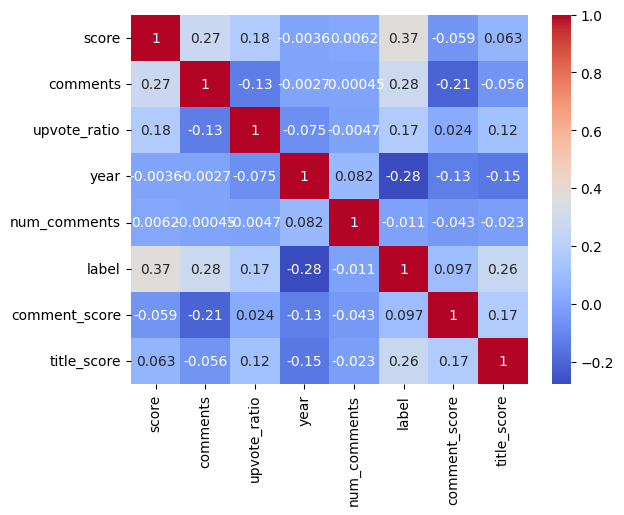

In [20]:
corr = new_final_data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

In [21]:
columns_to_drop = list(set(new_final_data.columns) - set(corr.columns))
print("Columns to not consider : ",columns_to_drop)
new_final_data = new_final_data.drop(columns_to_drop, axis=1)
new_final_data

Columns to not consider :  ['date-time', 'post_id', 'flair_text', 'post_url']


,score,comments,upvote_ratio,year,num_comments,label,comment_score,title_score
1867,344,139,0.89,2022,29,2,2,0
2154,630,4,0.95,2022,10,2,2,2
1530,3802,177,0.97,2021,9,1,1,2
298,628,93,0.96,2017,34,2,2,0
1914,622,36,0.97,2022,359,2,2,2
...,...,...,...,...,...,...,...,...
1638,425,139,0.96,2021,6,2,2,2
1095,615,195,0.92,2020,8,2,2,2
1130,593,61,0.99,2020,18,2,2,2
1294,313,197,0.94,2021,172,1,1,1


In [22]:
X_train, X_test, y_train, y_test = train_test_split(new_final_data.drop('label', axis=1), new_final_data['label'], test_size=0.2, random_state=42)
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0, 0,
       2, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 2,
       0, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1,
       0, 2, 0, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 1, 2, 0, 2,
       0, 2, 1, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1,
       1, 0, 1, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1, 0, 1, 0,
       1, 2, 0, 2, 0, 2, 2, 0, 2, 1, 2, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0,
       0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 0, 1, 2, 1, 0, 1, 1, 2, 2, 0, 0, 1,
       0, 2, 2, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1,
       2, 2, 1, 0, 1, 2, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 1, 1, 2, 0, 1,
       2, 2, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 2,
       0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 2, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2,

In [23]:
print("The Decision tree classification report : \n")
logreg_report = classification_report(y_test, y_pred_logreg, output_dict=True)
print(classification_report(y_test, y_pred_logreg))

The Decision tree classification report : 

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       113
           1       0.70      0.78      0.74       134
           2       0.81      0.76      0.78       143

    accuracy                           0.79       390
   macro avg       0.80      0.79      0.79       390
weighted avg       0.79      0.79      0.79       390



In [24]:
X_train, X_test, y_train, y_test = train_test_split(new_final_data.drop('label', axis=1), new_final_data['label'], test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_dt = clf.predict(X_test)
y_pred_dt

array([2, 1, 1, 1, 0, 1, 2, 1, 1, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1,
       2, 0, 1, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2, 2,
       0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 1,
       0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 2,
       0, 2, 1, 1, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 2,
       1, 0, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2,
       0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0,
       1, 2, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 1, 0, 1, 1, 2, 2, 2, 0, 1, 2, 2, 0, 1, 1, 2, 2, 0, 0, 1,
       0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 1, 2, 0, 2, 2, 2, 1,
       2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 1, 0, 1,
       2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 1, 2,
       0, 2, 0, 2, 2, 1, 0, 2, 0, 2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1,
       1, 1, 0, 1, 2, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2,

In [25]:
print("The Logistic regression classification report : \n")
dt_report = classification_report(y_test, y_pred_dt, output_dict=True)
print(classification_report(y_test, y_pred_dt))

The Logistic regression classification report : 

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       113
           1       0.85      0.85      0.85       134
           2       0.84      0.87      0.86       143

    accuracy                           0.86       390
   macro avg       0.87      0.86      0.87       390
weighted avg       0.86      0.86      0.86       390



In [26]:
X_train, X_test, y_train, y_test = train_test_split(new_final_data.drop('label', axis=1), new_final_data['label'], test_size=0.2)
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_pred_svm

array([2, 0, 0, 2, 1, 1, 2, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 2, 2, 0, 1,
       2, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 1, 0, 1, 2,
       0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1,
       2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 1,
       1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 2, 0, 1, 1,
       1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2,
       2, 1, 2, 2, 1, 0, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2,
       1, 0, 1, 0, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1,
       0, 2, 0, 0, 1, 2, 0, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1, 0, 2,
       2, 0, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 0, 2, 0, 2, 2, 1,
       1, 1, 2, 2, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       2, 0, 1, 0, 1, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2, 2, 2, 0, 1, 2,
       1, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 1,

In [27]:
print("The SVM classification report : \n")
svm_report = classification_report(y_test, y_pred_svm, output_dict=True)
print(classification_report(y_test, y_pred_svm))

The SVM classification report : 

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       102
           1       0.90      0.87      0.89       152
           2       0.84      0.92      0.88       136

    accuracy                           0.89       390
   macro avg       0.90      0.90      0.90       390
weighted avg       0.90      0.89      0.90       390



In [28]:
X_train, X_test, y_train, y_test = train_test_split(new_final_data.drop('label', axis=1), new_final_data['label'], test_size=0.2)
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
y_pred_rfc

array([2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2, 1, 2, 2, 0, 0, 1,
       1, 1, 2, 0, 1, 2, 1, 0, 2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0,
       2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2, 2, 0, 2, 1, 1, 1, 1, 2, 0, 1,
       2, 0, 2, 1, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1,
       0, 0, 2, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1, 1,
       1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1,
       1, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2,
       1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 2,
       1, 1, 2, 2, 0, 0, 2, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2,
       2, 0, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0,
       2, 2, 2, 2, 1, 1, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 0, 2, 2,
       1, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 2, 2, 2,
       0, 0, 1, 0, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 1, 2, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 0, 0, 1, 2,

In [29]:
print("The RFC classification report : \n")
rfc_report = classification_report(y_test, y_pred_rfc, output_dict=True)
print(classification_report(y_test, y_pred_rfc))

The RFC classification report : 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       108
           1       0.93      0.90      0.91       151
           2       0.86      0.92      0.89       131

    accuracy                           0.92       390
   macro avg       0.92      0.92      0.92       390
weighted avg       0.92      0.92      0.92       390



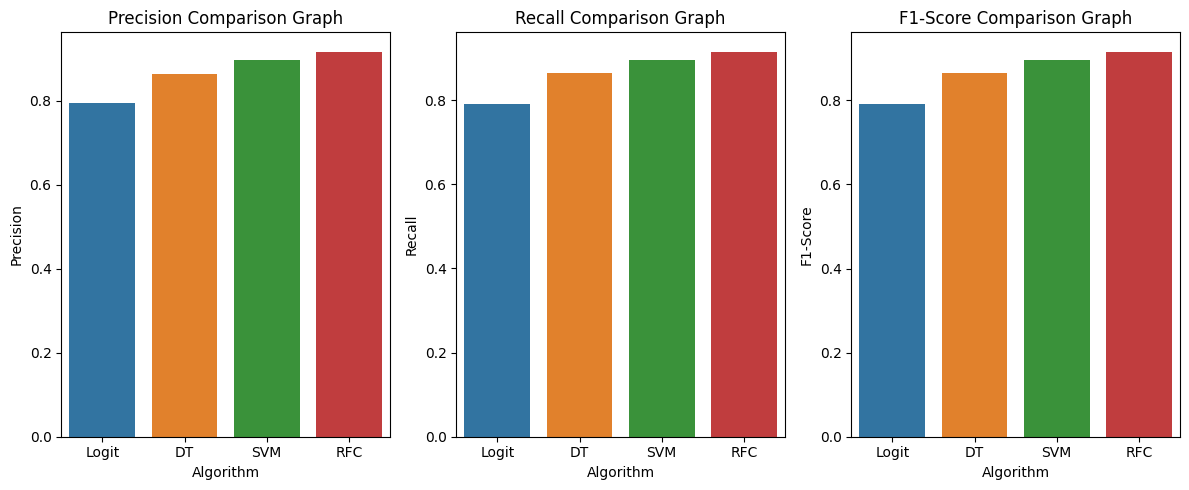

In [30]:
x = ['Logit', 'DT', 'SVM', 'RFC']
precision = [logreg_report['weighted avg']['precision'], dt_report['weighted avg']['precision'], 
             svm_report['weighted avg']['precision'], rfc_report['weighted avg']['precision']]
recall = [logreg_report['weighted avg']['recall'], dt_report['weighted avg']['recall'], 
          svm_report['weighted avg']['recall'], rfc_report['weighted avg']['recall']]
f1_score = [logreg_report['weighted avg']['f1-score'], dt_report['weighted avg']['f1-score'], 
            svm_report['weighted avg']['f1-score'], rfc_report['weighted avg']['f1-score']]

fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

sns.barplot(x=x, y=precision, ax=axes[0])
axes[0].set_title('Precision Comparison Graph')
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('Precision')

sns.barplot(x=x, y=recall, ax=axes[1])
axes[1].set_title('Recall Comparison Graph')
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Recall')

sns.barplot(x=x, y=f1_score, ax=axes[2])
axes[2].set_title('F1-Score Comparison Graph')
axes[2].set_xlabel('Algorithm')
axes[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()